In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 10 15:10:00 2018

@author: juliana
"""


import h5py
import os
import json
import cv2
import time
import math
import optparse
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as mpl
import seaborn as sns
import pyvttbl as pt
import multiprocessing as mp
import tifffile as tf
from collections import namedtuple
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

from pipeline.python.utils import natural_keys, replace_root, print_elapsed_time
import pipeline.python.traces.combine_runs as cb
import pipeline.python.paradigm.align_acquisition_events as acq
import pipeline.python.visualization.plot_psths_from_dataframe as vis
from pipeline.python.traces.utils import load_TID


/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def extract_options(options):

    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir',
                          default='/nas/volume1/2photon/data',
                          help='data root dir (dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid',
                          default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session',
                          default='', help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition',
                          default='FOV1', help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-T', '--trace-type', action='store', dest='trace_type',
                          default='raw', help="trace type [default: 'raw']")

    parser.add_option('-R', '--run', dest='run_list', default=[], nargs=1,
                          action='append',
                          help="run ID in order of runs")
    parser.add_option('-t', '--traceid', dest='traceid_list', default=[], nargs=1,
                          action='append',
                          help="trace ID in order of runs")
    parser.add_option('-n', '--nruns', action='store', dest='nruns', default=1, help="Number of consecutive runs if combined")

    parser.add_option('--slurm', action='store_true', dest='slurm', default=False, help="set if running as SLURM job on Odyssey")
    parser.add_option('--par', action='store_true', dest='multiproc', default=False, help="set if want to run MP on roi stats, when possible")
    parser.add_option('--nproc', action='store', dest='nprocesses', default=4, help="N processes if running in par (default=4)")

    parser.add_option('--combo', action='store_true', dest='combined', default=False, help="Set if using combined runs with same default name (blobs_run1, blobs_run2, etc.)")


    # Pupil filtering info:
    parser.add_option('--no-pupil', action="store_false",
                      dest="filter_pupil", default=True, help="Set flag NOT to filter PSTH traces by pupil threshold params")
    parser.add_option('-s', '--radius-min', action="store",
                      dest="pupil_radius_min", default=25, help="Cut-off for smnallest pupil radius, if --pupil set [default: 25]")
    parser.add_option('-B', '--radius-max', action="store",
                      dest="pupil_radius_max", default=65, help="Cut-off for biggest pupil radius, if --pupil set [default: 65]")
    parser.add_option('-d', '--dist', action="store",
                      dest="pupil_dist_thr", default=5, help="Cut-off for pupil distance from start, if --pupil set [default: 5]")

    (options, args) = parser.parse_args(options)

    return options

In [3]:
def load_roi_dataframe(roidata_filepath):

    fn_parts = os.path.split(roidata_filepath)[-1].split('_')
    roidata_hash = fn_parts[1]
    trace_type = os.path.splitext(fn_parts[-1])[0]

    df_list = []

    df = pd.HDFStore(roidata_filepath, 'r')
    datakeys = df.keys()
    if 'roi' in datakeys[0]:
        for roi in datakeys:
            if '/' in roi:
                roiname = roi[1:]
            else:
                roiname = roi
            dfr = df[roi]
            dfr['roi'] = pd.Series(np.tile(roiname, (len(dfr .index),)), index=dfr.index)
            df_list.append(dfr)
        DATA = pd.concat(df_list, axis=0, ignore_index=True)
        datakey = '%s_%s' % (trace_type, roidata_hash)
    else:
        print "Found %i datakeys" % len(datakeys)
        datakey = datakeys[0]
        df.close()
        del df
        DATA = pd.read_hdf(roidata_filepath, datakey)
        #DATA = df[datakey]

    return DATA, datakey

# Set options and load data

In [4]:
options = ['-D', '/mnt/odyssey', '-i', 'CE077', '-S', '20180413', '-A', 'FOV1_zoom1x',
           '-T', 'np_subtracted', '--no-pupil',
           '-R', 'gratings_run1', '-t', 'traces001',
           '-n', '1']

In [5]:
options = extract_options(options)

rootdir = options.rootdir
animalid = options.animalid
session = options.session
acquisition = options.acquisition
slurm = options.slurm
if slurm is True:
    rootdir = '/n/coxfs01/2p-data'

trace_type = options.trace_type

run_list = options.run_list
traceid_list = options.traceid_list

filter_pupil = options.filter_pupil
pupil_radius_max = float(options.pupil_radius_max)
pupil_radius_min = float(options.pupil_radius_min)
pupil_dist_thr = float(options.pupil_dist_thr)
pupil_max_nblinks = 0

multiproc = options.multiproc
nprocesses = int(options.nprocesses)
combined = options.combined
nruns = int(options.nruns)

acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)
if combined is False:
    runfolder = run_list[0]
    traceid = traceid_list[0]
    with open(os.path.join(acquisition_dir, runfolder, 'traces', 'traceids_%s.json' % runfolder), 'r') as f:
        tdict = json.load(f)
    tracefolder = '%s_%s' % (traceid, tdict[traceid]['trace_hash'])
    traceid_dir = os.path.join(rootdir, animalid, session, acquisition, runfolder, 'traces', tracefolder)
else:
    assert len(run_list) == nruns, "Incorrect runs or number of runs (%i) specified!\n%s" % (nruns, str(run_list))
    runfolder = '_'.join(run_list)
    if len(traceid_list)==1:
        traceid = '_'.join([traceid_list[0] for i in range(nruns)])
    traceid_dir = os.path.join(rootdir, animalid, session, acquisition, runfolder, traceid)


print(traceid_dir)
assert os.path.exists(traceid_dir), "Specified traceid-dir does not exist!"

/mnt/odyssey/CE077/20180413/FOV1_zoom1x/gratings_run1/traces/traces001_3183c3


#### Load ROIDATA file

In [6]:
roidf_fn = [i for i in os.listdir(traceid_dir) if i.endswith('hdf5') and 'ROIDATA' in i and trace_type in i][0]
roidata_filepath = os.path.join(traceid_dir, roidf_fn) #'ROIDATA_098054_626d01_raw.hdf5')
DATA, datakey = load_roi_dataframe(roidata_filepath)

transform_dict, object_transformations = vis.get_object_transforms(DATA)
trans_types = object_transformations.keys()


[0, 45, 90, 135]
[0.10000000000000001, 0.5]


In [7]:
print datakey

subtracted_2d2e3d


#### Filter by pupil data, if relevant:

In [8]:
if filter_pupil is True:
    pupil_params = acq.set_pupil_params(radius_min=pupil_radius_min,
                                        radius_max=pupil_radius_max,
                                        dist_thr=pupil_dist_thr,
                                        create_empty=False)
elif filter_pupil is False:
    pupil_params = acq.set_pupil_params(create_empty=True)

#### Get stimulus info:

In [9]:

rundir = os.path.join(rootdir, animalid, session, acquisition, runfolder)

if combined is True:
    stimconfigs_fpath = os.path.join(traceid_dir, 'stimulus_configs.json')
else:
    stimconfigs_fpath = os.path.join(rundir, 'paradigm', 'stimulus_configs.json')

with open(stimconfigs_fpath, 'r') as f:
    stimconfigs = json.load(f)

print "Loaded %i stimulus configurations." % len(stimconfigs.keys())


Loaded 8 stimulus configurations.


In [10]:
%matplotlib notebook

# Look at ORIENTATION dataset

In [11]:
roi_list = sorted(list(set(DATA['roi'])), key=natural_keys)
config_list = sorted(list(set(DATA['config'])), key=natural_keys)


In [12]:
curr_sf = 0.5
configs = sorted([c for c in config_list if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])
print configs

[u'config001', u'config003', u'config002', u'config004']


In [13]:
df = DATA[DATA['config'].isin(configs)]
trial_list = sorted(list(set(df['trial'])), key=natural_keys)
print "N trials:", len(trial_list)

N trials: 40


In [14]:
roi = 'roi00002'
dff_grps = DATA[DATA['roi']==roi][['config', 'trial', 'df', 'tsec']].groupby(['config', 'trial'])['df'].apply(np.array)

<IPython.core.display.Javascript object>


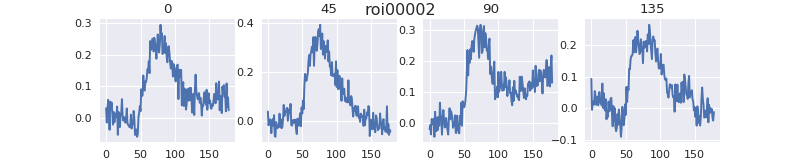

In [15]:
#conf = 'config001'
sns.set()
fig = pl.figure(figsize=(10,2))
pi = 1
for conf in configs:
    ax = fig.add_subplot(1,4,pi)
    tmat = np.array([dff_grps.xs(conf, level='config').values[i] for i in range(len(dff_grps.xs(conf, level='config')))])
    meandf = np.mean(tmat, axis=0)
    ax.plot(meandf, label=stimconfigs[conf]['rotation'])
    pl.title(stimconfigs[conf]['rotation'])
    pi += 1
sns.despine()
pl.suptitle(roi)

### Overall average to orientation:

#### Format DF so each column 
##### Each column is nRois * nFramesPerTrial * nTrialsPerConfig for a given stimulus config.
##### Resulting matrix should be M x N, where 
    M = nRois * nFramesPerTrial * nTrialsPerConfig
    N = nConfigs

In [158]:
nrois = len(roi_list)
dfcol = []
for conf in configs:
    dfvals =  df[df['config']==conf]['df'].values
    ori = stimconfigs[conf]['rotation']
    dfcol.append(pd.DataFrame({ori: dfvals}))
dfcols = pd.concat(dfcol, axis=1)


In [165]:
dfcols.shape

(214800, 4)

#### Calculate all pair-wise corr between columns:

In [159]:
corr_by_config = dfcols.corr(method='pearson')
print corr_by_config

          0         45        90        135
0    1.000000  0.093864  0.079531  0.050876
45   0.093864  1.000000  0.083465  0.085084
90   0.079531  0.083465  1.000000  0.067155
135  0.050876  0.085084  0.067155  1.000000


<IPython.core.display.Javascript object>


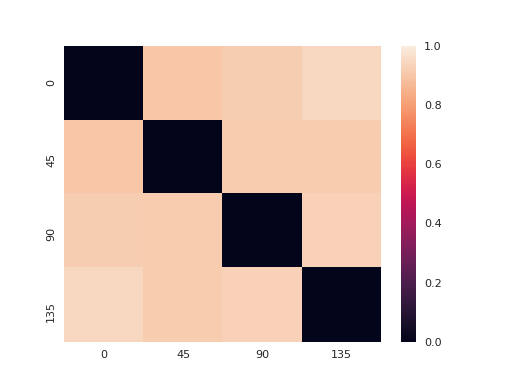

In [220]:
pl.figure()

# Generate a mask for the upper triangle
corr_mask = np.zeros_like(corr_by_config, dtype=np.bool)
corr_mask[np.triu_indices_from(corr_mask)] = True

# Use diverging cmap:
div_cmap = sns.diverging_palette(145, 280, s=85, l=25)

#sns.heatmap(corr_by_config)
# sns.heatmap(corr_by_config, mask=corr_mask, cmap=div_cmap, vmax=.25, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
vmax = 1
# sns.heatmap(1-corr_by_config, cmap=div_cmap, vmax=vmax, vmin=-1*vmax, center=0,
# #             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.heatmap(1-corr_by_config, cmap=div_cmap, center=0, vmax = 1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(1-corr_by_config, vmax=1) #, cmap=div_cmap)

### Trial-to-trial correlations:

#### Format DF so each column 
##### Each column is nRois * nFramesPerTrial for 1 trial in each config. 
##### Resulting matrix should be M x N, where 
    M = nRois * nFramesPerTrial, 
    N = nConfigs * nTrialsPerConfig.

In [161]:
nrois = len(roi_list)
dftrials_list = []
for conf in configs:
    trials = sorted(list(set(df[df['config']==conf]['trial'])), key=natural_keys)
    for ti, trial in enumerate(trials):
        dfvals =  df[((df['config']==conf) & (df['trial']==trial))]['df'].values
        ori = int(stimconfigs[conf]['rotation'])
        dftrials_list.append(pd.DataFrame({'%i_%i' % (ori, ti): dfvals}))
dftrials = pd.concat(dftrials_list, axis=1)


In [168]:
dftrials.shape

(21480, 40)

<IPython.core.display.Javascript object>


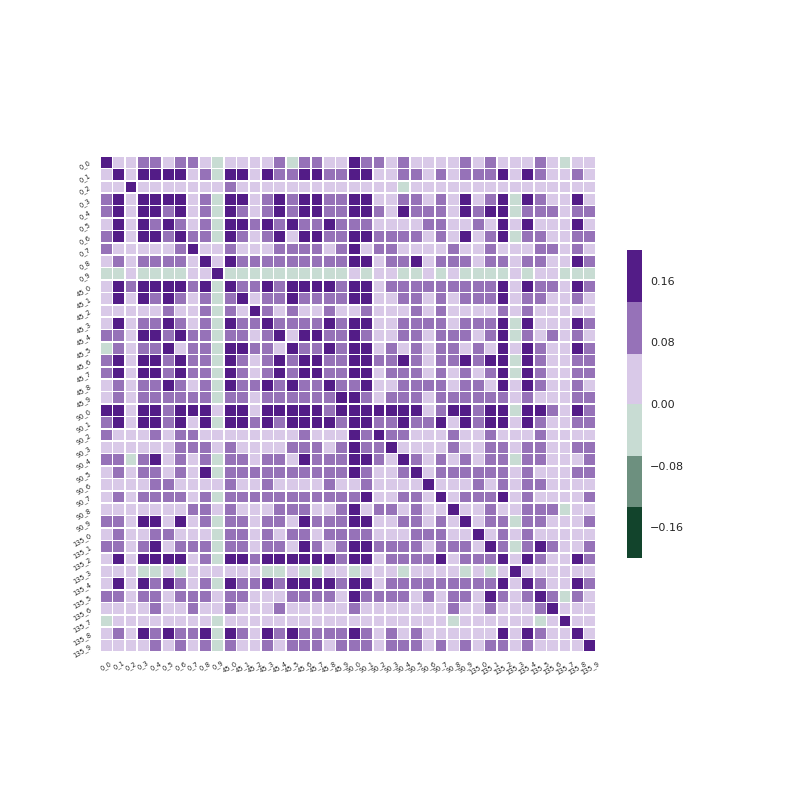

In [288]:
corrs_trial =  dftrials.corr(method='pearson')
#print corrs_trial

pl.figure(figsize=(10,10))

# Generate a mask for the upper triangle
corr_mask = np.zeros_like(corrs_trial, dtype=np.bool)
corr_mask[np.triu_indices_from(corr_mask)] = True

# Use diverging cmap:
div_cmap = sns.diverging_palette(145, 280, s=85, l=25)

vmax = 0.2
#sns.heatmap(corr_by_config)
# sns.heatmap(corr_by_config, mask=corr_mask, cmap=div_cmap, vmax=.25, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = sns.heatmap(corrs_trial, cmap=div_cmap, vmax=vmax, vmin=-1*vmax, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30, fontsize=6)
pl.show()

# Look at each ROI x Trial x Config
i.e., don't collapse all ROIs

In [18]:
trialdict = dict((conf, sorted(list(set(df[df['config']==conf]['trial'])), key=natural_keys)) for conf in configs)


In [21]:
nrois = len(roi_list)
trialdict = dict((conf, sorted(list(set(df[df['config']==conf]['trial'])), key=natural_keys)) for conf in configs)
dfrois_list = []
for ri, roi in enumerate(roi_list):
    if ri % 10 == 0:
        print ri
    for conf in configs:
        print conf
        trials = sorted(list(set(df[df['config']==conf]['trial'])), key=natural_keys)
        for ti, trial in enumerate(trials):
            dfvals =  df[((df['roi']==roi) & (df['config']==conf) & (df['trial']==trial))]['df'].values
            dfrois_list.append(pd.DataFrame({'r%i_%i_%i' % (ri, ori, ti): dfvals}))
dfrois = pd.concat(dfrois_list, axis=1)


0
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
10
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
20
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
config004
config001
config003
config002
co

In [22]:
dfrois.head()

,r0_45_0,r0_45_1,r0_45_2,r0_45_3,r0_45_4,r0_45_5,r0_45_6,r0_45_7,r0_45_8,r0_45_9,...,r119_45_0,r119_45_1,r119_45_2,r119_45_3,r119_45_4,r119_45_5,r119_45_6,r119_45_7,r119_45_8,r119_45_9
0,0.014963,0.029408,0.004237,-0.105145,-0.231993,-0.074960,-0.047717,0.032907,-0.120590,0.154213,...,-0.084687,0.075745,-0.016035,-0.121663,-0.083308,0.231928,-0.095574,-0.070031,0.118200,-0.232654
1,-0.241323,0.179256,-0.045793,0.056763,0.017208,-0.172141,0.013582,0.157895,0.104789,0.029584,...,-0.028304,-0.115232,0.064635,0.150725,-0.016346,0.093349,-0.032433,-0.028539,0.181286,0.010134
2,-0.093446,-0.053832,-0.138385,0.002385,-0.045821,0.143471,0.090847,-0.151543,-0.084582,0.278369,...,-0.154576,0.011763,0.058354,0.207789,0.107916,-0.043675,-0.195712,-0.077628,-0.225633,-0.135281
3,0.088467,0.212847,-0.127948,-0.052012,-0.126408,0.180423,-0.098427,-0.037838,-0.118694,0.062946,...,-0.034916,0.066658,0.065899,0.125620,0.176961,-0.085736,0.034513,0.068058,0.022750,-0.130401
4,-0.098783,0.015843,-0.221464,-0.067650,0.067180,-0.114484,0.018971,-0.023002,-0.047681,-0.065658,...,-0.010257,0.185996,0.075272,-0.038495,-0.142261,0.143071,-0.059169,0.041378,0.060281,0.011146


In [32]:
# tmp
fpath = '/home/Downloads/dfrois.pkl'
dfrois.to_pickle(fpath)

# to load:
# df = pd.read_pickle(fpath)

del dfrois

NameError: name 'dfrois' is not defined

In [24]:
corrs_roi =  dfrois.corr(method='pearson')
#print corrs_trial


In [26]:
corrs_roi.head()

,r0_45_0,r0_45_1,r0_45_2,r0_45_3,r0_45_4,r0_45_5,r0_45_6,r0_45_7,r0_45_8,r0_45_9,...,r119_45_0,r119_45_1,r119_45_2,r119_45_3,r119_45_4,r119_45_5,r119_45_6,r119_45_7,r119_45_8,r119_45_9
r0_45_0,1.000000,0.113890,0.093725,0.035889,0.144929,-0.092104,0.076797,0.140835,0.097418,-0.010598,...,0.002325,0.205203,0.180599,-0.014062,0.150222,0.251311,0.155889,0.081131,0.059386,0.061663
r0_45_1,0.113890,1.000000,0.054797,-0.029128,-0.080218,0.071844,0.051042,0.043052,0.081526,0.071274,...,0.170989,-0.017690,0.026555,0.102967,0.085259,0.006434,-0.000087,0.058103,0.016201,0.121589
r0_45_2,0.093725,0.054797,1.000000,0.037126,0.004971,-0.055245,0.055664,0.021011,0.057218,-0.041772,...,0.060628,0.169092,0.203644,0.086035,0.129826,0.056631,0.022342,-0.015045,-0.034741,0.142042
r0_45_3,0.035889,-0.029128,0.037126,1.000000,0.220966,0.098966,0.140346,0.031548,0.109581,-0.038930,...,-0.132559,0.007536,0.101969,-0.010535,0.153423,0.029556,0.107562,0.150806,0.122472,0.105266
r0_45_4,0.144929,-0.080218,0.004971,0.220966,1.000000,-0.018293,-0.029063,0.076275,0.086660,0.044447,...,-0.127425,0.100848,0.122053,0.027139,0.183755,0.135394,0.248283,0.066458,0.020323,0.111416


<IPython.core.display.Javascript object>


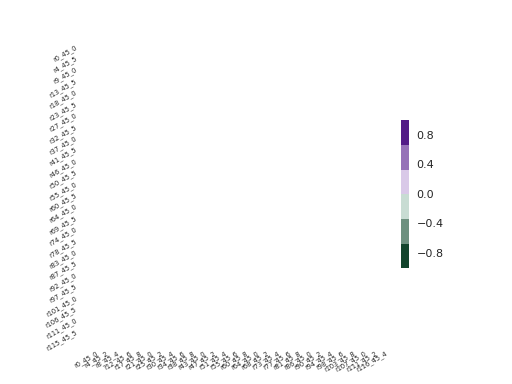

In [40]:

pl.figure()

# Generate a mask for the upper triangle
corr_mask = np.zeros_like(corrs_roi, dtype=np.bool)
corr_mask[np.triu_indices_from(corr_mask)] = True

# Use diverging cmap:
#div_cmap = sns.diverging_palette(145, 280, s=85, l=25)

vmax = 1
#sns.heatmap(corr_by_config)
# sns.heatmap(corr_by_config, mask=corr_mask, cmap=div_cmap, vmax=.25, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = sns.heatmap(corrs_roi, vmax=vmax, vmin=-1*vmax, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30, fontsize=6)
#pl.show()

# View similarities:

#### Calculate euclidean distance between all pairs of comparisons:

In [280]:
dist_method = lambda column1, column2: pd.np.linalg.norm(column1 - column2)
dist_mat = corrs_trial.apply(lambda col1: corrs_trial.apply(lambda col2: dist_method(col1, col2)))
dist_mat.head()

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,135_0,135_1,135_2,135_3,135_4,135_5,135_6,135_7,135_8,135_9
0_0,0.000000,1.396311,1.450135,1.363281,1.333451,1.494652,1.338446,1.339078,1.446525,1.499979,...,1.419904,1.269876,1.436871,1.470187,1.455063,1.321274,1.354005,1.459357,1.470598,1.364081
0_1,1.396311,0.000000,1.496421,1.229143,1.206170,1.234575,1.223698,1.427763,1.294884,1.666140,...,1.342792,1.313120,1.174999,1.556080,1.220194,1.353770,1.418554,1.490192,1.263598,1.360515
0_2,1.450135,1.496421,0.000000,1.530395,1.536336,1.459393,1.493301,1.380537,1.422993,1.417332,...,1.414354,1.489006,1.536247,1.414752,1.459803,1.425126,1.370045,1.373238,1.436047,1.418167
0_3,1.363281,1.229143,1.530395,0.000000,1.186954,1.253720,1.205997,1.401050,1.299899,1.682427,...,1.371775,1.273085,1.192794,1.589580,1.219102,1.343770,1.409661,1.542468,1.251328,1.374206
0_4,1.333451,1.206170,1.536336,1.186954,0.000000,1.307898,1.195179,1.392591,1.293871,1.676822,...,1.374411,1.237994,1.189060,1.596694,1.268228,1.323726,1.392289,1.528729,1.308892,1.355905


<IPython.core.display.Javascript object>


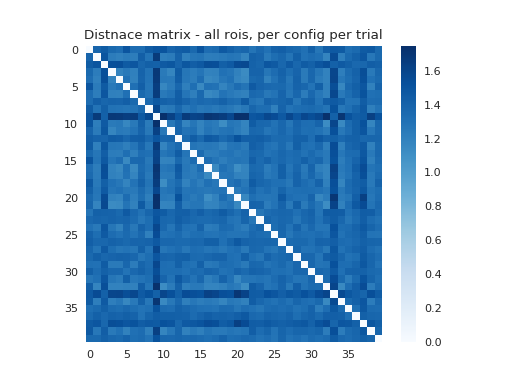

In [282]:
pl.figure()
pl.imshow(dist_mat, zorder=2, cmap='Blues', interpolation='nearest')
pl.colorbar();
pl.title("Distnace matrix - all rois, per config per trial")

### Visualize with MDS

In [284]:
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [235]:
mds_model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
mds_out = mds_model.fit_transform(dist_mat)


In [285]:
oris = [str(name.split('_')[0]) for name in corrs_trial.columns] # add config value for easy indexing later
dist_configs = dist_mat.copy()
D = pd.concat([dist_configs, pd.DataFrame(data=oris, columns=['config'], index=dist_configs.index)], axis = 1)

In [286]:
D.head()

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,135_1,135_2,135_3,135_4,135_5,135_6,135_7,135_8,135_9,config
0_0,0.000000,1.396311,1.450135,1.363281,1.333451,1.494652,1.338446,1.339078,1.446525,1.499979,...,1.269876,1.436871,1.470187,1.455063,1.321274,1.354005,1.459357,1.470598,1.364081,0
0_1,1.396311,0.000000,1.496421,1.229143,1.206170,1.234575,1.223698,1.427763,1.294884,1.666140,...,1.313120,1.174999,1.556080,1.220194,1.353770,1.418554,1.490192,1.263598,1.360515,0
0_2,1.450135,1.496421,0.000000,1.530395,1.536336,1.459393,1.493301,1.380537,1.422993,1.417332,...,1.489006,1.536247,1.414752,1.459803,1.425126,1.370045,1.373238,1.436047,1.418167,0
0_3,1.363281,1.229143,1.530395,0.000000,1.186954,1.253720,1.205997,1.401050,1.299899,1.682427,...,1.273085,1.192794,1.589580,1.219102,1.343770,1.409661,1.542468,1.251328,1.374206,0
0_4,1.333451,1.206170,1.536336,1.186954,0.000000,1.307898,1.195179,1.392591,1.293871,1.676822,...,1.237994,1.189060,1.596694,1.268228,1.323726,1.392289,1.528729,1.308892,1.355905,0


#### Visualize similarity of sturcture of activity patterns (trial-to-trial):

<IPython.core.display.Javascript object>


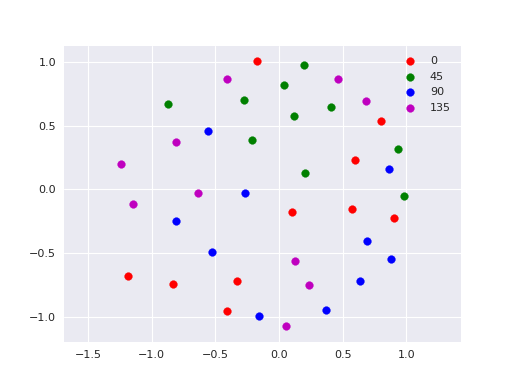

0 10
45 10
90 10
135 10


In [287]:
fig = pl.figure()
ax = fig.add_subplot(1,1,1)

ori_list = sorted([int(o) for o in list(set(oris))])
color_list = ['r','g','b', 'm']
for ix, ori  in enumerate(ori_list):
    idxs = [i for i in range(len(D['config'])) if int(D['config'][i]) == ori]
    print ori, len(idxs)
#     ax.scatter(D.loc[idxs,:],
#                D.loc[idxs,:],
#                #c = color
#                s = 50)
    ax.scatter(mds_out[idxs, 0], mds_out[idxs, 1], c=color_list[ix], label=ori)
pl.axis('equal');
pl.legend()

In [273]:
[i for i in range(len(D['config'])) if int(D['config'][i]) == ori]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [274]:
ori

0

In [277]:
i

39